In [4]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wandb
from pathlib import Path


In [5]:

csv_path = r"C:\Users\mktha\Documents\projects\felix\data\S12Dataset3(mag).csv"
df_mag = pd.read_csv(csv_path)

# print the shape
print(df_mag.shape)

print(df_mag.head())

(4592, 409)
   0.1  0.1.1  5.4   7.3   0.7   4.9   9.7  8.6  0.0100969130424835  \
0  0.1    0.2  1.0   1.8   5.4  11.5  12.0  5.0            0.003273   
1  0.1    0.2  4.5   3.6  21.1   9.8   0.5  7.9            0.016966   
2  0.1    0.3  0.5  10.2   3.8  11.7   1.8  0.7            0.009117   
3  0.1    0.6  3.2   5.9  20.5   3.2   5.1  5.5            0.015114   
4  0.1    1.0  0.1   4.7  11.6   1.9   5.3  5.5            0.001050   

   0.010164111824825  ...  0.674982624819452  0.704052939287359  \
0           0.003298  ...           0.238371           0.236567   
1           0.017086  ...           0.056099           0.061041   
2           0.009153  ...           0.294719           0.285805   
3           0.015091  ...           0.171265           0.233325   
4           0.001057  ...           0.233271           0.235958   

   0.729433851259858  0.751903819580728  0.771786786892162  0.789108217711211  \
0           0.234809           0.233253           0.232010           0.231160

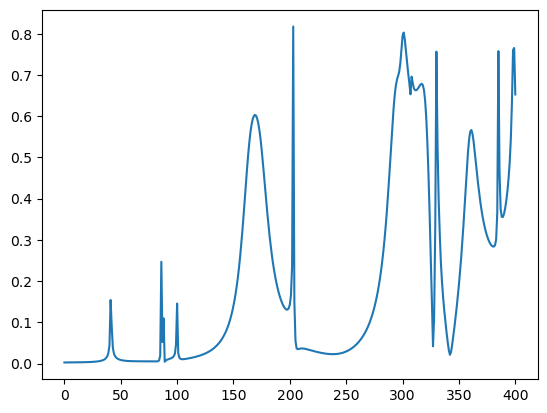

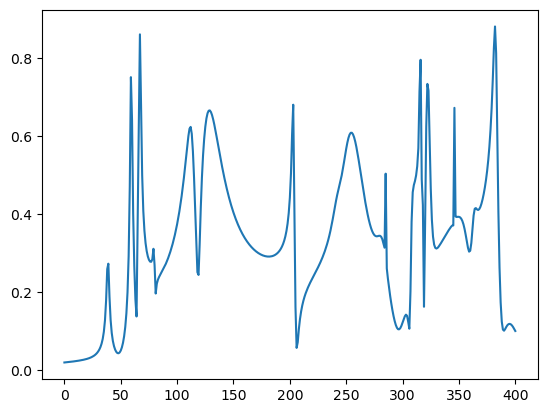

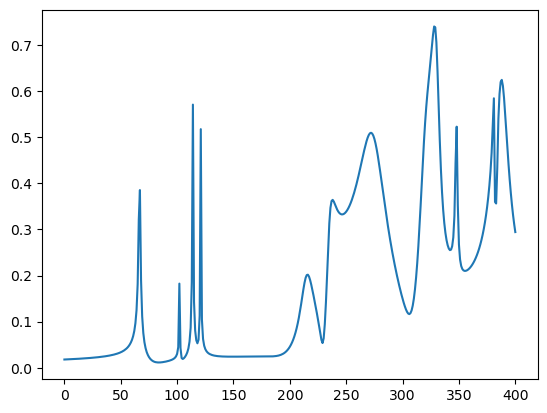

In [6]:
indices = np.random.randint(0, len(df_mag), size=3)
for i in indices:
    mag = df_mag.iloc[i][8:].to_numpy()
    # phase = df_phase.iloc[i][8:].to_numpy()
    # convert phase to radians
    # phase = np.deg2rad(phase)
    # real = mag * np.cos(phase)
    # imag = mag * np.sin(phase)
    # plot mag
    plt.plot(mag)
    
    plt.show()
    

In [ ]:

df1 = df_mag
param1 = df_mag['eps1 ']
param2 = df_mag['eps2 ']
param3 = df_mag['eps3 ']
param4 = df_mag['eps4 ']
param5 = df_mag['t1 [mm]']
param6 = df_mag['t2 [mm]']
param7 = df_mag['t3 [mm]']
param8 = df_mag['t4 [mm]']
# get the columns from 9 to the end
mag_values = df1.iloc[:, 8:]

# convert to numpy array
param1 = param1.values
param2 = param2.values
param3 = param3.values
param4 = param4.values
param5 = param5.values
param6 = param6.values
param7 = param7.values
param8 = param8.values
mag_values = mag_values.to_numpy()
# values = values[:, 50:51]

# standardize
param1_scaler = preprocessing.StandardScaler()
param1 = param1_scaler.fit_transform(param1.reshape(-1, 1))
param2_scaler = preprocessing.StandardScaler()
param2 = param2_scaler.fit_transform(param2.reshape(-1, 1))
param3_scaler = preprocessing.StandardScaler()
param3 = param3_scaler.fit_transform(param3.reshape(-1, 1))
param4_scaler = preprocessing.StandardScaler()
param4 = param4_scaler.fit_transform(param4.reshape(-1, 1))
param5_scaler = preprocessing.StandardScaler()
param5 = param5_scaler.fit_transform(param5.reshape(-1, 1))
param6_scaler = preprocessing.StandardScaler()
param6 = param6_scaler.fit_transform(param6.reshape(-1, 1))
param7_scaler = preprocessing.StandardScaler()
param7 = param7_scaler.fit_transform(param7.reshape(-1, 1))
param8_scaler = preprocessing.StandardScaler()
param8 = param8_scaler.fit_transform(param8.reshape(-1, 1))
values_scaler = preprocessing.StandardScaler()
values = values_scaler.fit_transform(values)

inputs = np.column_stack((param1, param2, param3, param4, param5, param6, param7, param8))
# split data
X_train, X_test, y_train, y_test = train_test_split(inputs, values, test_size=0.05, random_state=42)


In [ ]:
# setup config
config = {
    'lr': 0.0001,
    'batch_size': 32,
    'epochs': 300,
    'hidden_dim': 512,
    'dropout': 0.2,
    'num_layers': 15,
}

In [ ]:
# setup wandb
wandb.login()
# root_path = Path(r'C:\Users\mktha\Documents\projects\felix')

# model_dir = root_path / 'models'
wandb.init(project='Felix',
            name='',
            notes='',
            tags=[''],
            entity='mksthabet',
            config=config)
# # get run name
# run_name = wandb.run.name
# # get run dir
# run_dir = wandb.run.dir

# wandb.run.log_code('.')


In [ ]:

num_inputs = X_train.shape[1]
num_outputs = y_train.shape[1]

input_layer = tf.keras.Input(shape=(num_inputs,))
x = layers.Dense(config['hidden_dim'], activation='relu')(input_layer)
x = layers.LayerNormalization()(x)
x = layers.Dropout(config['dropout'])(x)
for layer in range(config['num_layers'] - 1):
    residual = x
    x = layers.Dense(config['hidden_dim'], activation='relu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(config['dropout'])(x)
    # x = layers.Dense(hidden_dim, activation='relu')(x)
    # x = layers.LayerNormalization()(x)
    # x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([x, residual])
output_layer = layers.Dense(num_outputs)(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'])
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='../models/best_model.h5', monitor='val_loss',
                                                 save_best_only=True, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
# wandb_callback = wandb.keras.WandbCallback(monitor="val_loss",
#                                                    log_weights=True, save_model=False)
model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], validation_data=(X_test, y_test),
          callbacks=[lr_callback, cp_callback, es_callback])

# plot the loss
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:

# predict
model = tf.keras.models.load_model('../models/best_model.h5')
y_pred = model.predict(X_test)
y_pred = values_scaler.inverse_transform(y_pred)
y_test = values_scaler.inverse_transform(y_test)


# calculate abs error along axis 1
error_abs = np.abs(y_pred - y_test)
square_error = np.square(y_pred - y_test)
mse = np.mean(np.square(error_abs))
mae = np.mean(error_abs)
print("MSE: ", mse)
print("MAE: ", mae)
